# Image Processing

Image processing constitutes a fundamental tool in computer vision and deep learning.
From a digital image, transformations are applied that allow modifying its visual
properties, extracting relevant information, or preparing data for training artificial
intelligence models. This text focuses on practical aspects of image processing in
Python, primarily using NumPy, PIL (Python Imaging Library), OpenCV, and PyTorch.

The necessary steps are described progressively to: load an image and represent it as a
matrix; apply basic color and brightness transformations; introduce noise; mask specific
regions; convert to grayscale; combine images through Mixup; and finally, perform
resizing and normalization for use in convolutional neural networks (CNNs). All of this
is integrated into a narrative oriented toward both conceptual and practical
understanding of each operation.

## Loading and Representing Images in Python

A digital color image is typically represented as a three-dimensional tensor of size
$H \times W \times C$, where $H$ is the height (in pixels), $W$ is the width, and $C$ is
the number of color channels, typically $C = 3$ for RGB images (red, green, blue). Each
pixel is stored as an integer value in the range $[0, 255]$ of type `uint8`, which allows
describing the intensity of each channel.

In Python, it is common to load an image and convert it to a NumPy array to be able to
manipulate it in a vectorized manner. The following shows how to perform this operation
with PIL and OpenCV, and how to visualize the image:

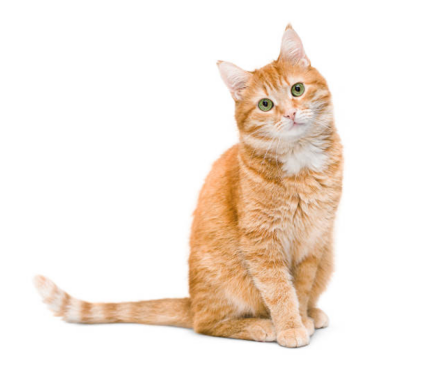

Image dimensions: (531, 612, 3)
Data type: uint8


In [1]:
# 3pps
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# Method 1: Using PIL (Python Imaging Library)
image_pil = Image.open(
    "/home/dani/Repositorios/unie-deep-learning/docs/assets/course/topic_02_mathematics/cat_image.jpg"
)
image_array = np.array(image_pil)

# Method 2: Using OpenCV
image_cv = cv2.imread(
    "/home/dani/Repositorios/unie-deep-learning/docs/assets/course/topic_02_mathematics/cat_image.jpg"
)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Visualize the image
plt.imshow(image_array)
plt.axis("off")
plt.show()

print(f"Image dimensions: {image_array.shape}")
print(f"Data type: {image_array.dtype}")

In this case, `image_array` is a NumPy array with typical shape `(height, width, 3)` and
data type `uint8`. The conversion from BGR to RGB in the case of OpenCV is necessary
because OpenCV uses the BGR format by default, while most visualization libraries and PIL
handle RGB.

This matrix representation is the foundation upon which the image processing
transformations described in subsequent sections are built.

## Basic Transformations on Images

Basic transformations allow modifying properties such as saturation, brightness, or noise
level, as well as masking specific regions or converting the image to grayscale. These
operations are essential both for classical preprocessing and for generating synthetic
data variations in data augmentation contexts.

### Saturation Modification

Saturation controls the intensity of colors. An increase in saturation produces more
vivid colors, while a decrease makes them more muted until reaching a grayscale image
when saturation is null.

In Python, a simple way to adjust saturation consists of using the `ImageEnhance` module
from PIL:

In [2]:
# 3pps
from PIL import ImageEnhance


def cambiar_saturacion(image, factor=1.5):
    """
    Factor > 1: Increases saturation.
    Factor < 1: Decreases saturation.
    Factor = 0: Grayscale image.
    """
    image_pil = Image.fromarray(image)
    enhancer = ImageEnhance.Color(image_pil)
    image_saturada = enhancer.enhance(factor)
    return np.array(image_saturada)


# Usage examples
imagen_mas_saturada = cambiar_saturacion(image_array, factor=2.0)
imagen_menos_saturada = cambiar_saturacion(image_array, factor=0.5)

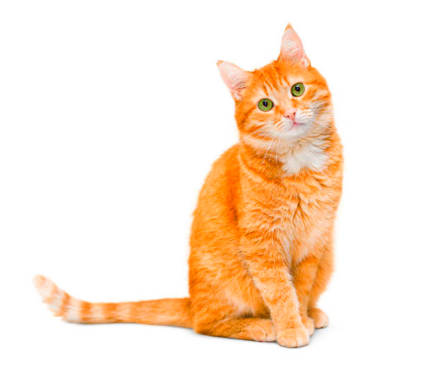

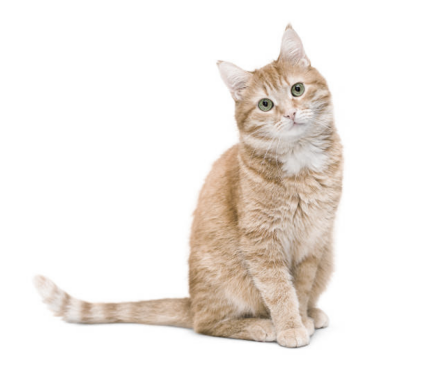

In [3]:
plt.imshow(imagen_mas_saturada)
plt.axis("off")
plt.show()

plt.imshow(imagen_menos_saturada)
plt.axis("off")
plt.show()

The `factor` parameter controls the degree of modification. Values greater than 1 produce
an increase in saturation, while values between 0 and 1 generate a progressively less
saturated image.

### Illumination Adjustment (Brightness)

Brightness reflects the global luminosity of the image. It can be modified through
PIL-based techniques or through arithmetic operations with NumPy.

A first approach, using `ImageEnhance.Brightness`, is as follows:

In [4]:
def cambiar_brillo(image, factor=1.3):
    """
    Factor > 1: Increases brightness.
    Factor < 1: Decreases brightness.
    """
    image_pil = Image.fromarray(image)
    enhancer = ImageEnhance.Brightness(image_pil)
    image_brillante = enhancer.enhance(factor)
    return np.array(image_brillante)

Alternatively, it is possible to adjust brightness directly with NumPy by adding a
constant value to all pixels. In this case, it is important to avoid undesired
saturations and maintain values in the valid range $[0, 255]$:

In [5]:
# Alternative with NumPy


def ajustar_brillo_numpy(image, valor=50):
    """Add a constant value to all pixels."""
    image_ajustada = np.clip(image.astype(np.int16) + valor, 0, 255)
    return image_ajustada.astype(np.uint8)


# Usage examples
imagen_mas_brillante = cambiar_brillo(image_array, factor=1.5)
imagen_mas_oscura = cambiar_brillo(image_array, factor=0.7)

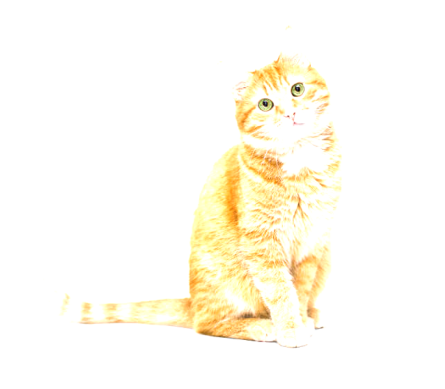

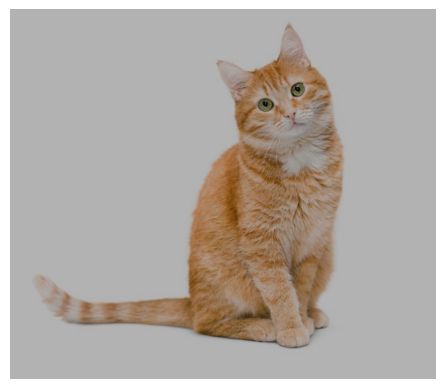

In [6]:
plt.imshow(imagen_mas_brillante)
plt.axis("off")
plt.show()

plt.imshow(imagen_mas_oscura)
plt.axis("off")
plt.show()

In the NumPy version, temporary conversion to `int16` avoids overflow problems when
adding positive values to a `uint8` array. The `np.clip` function guarantees that the
result remains within the allowed limits.

### Introduction of Gaussian Noise

Noise addition is a common technique in data augmentation to improve model robustness
against perturbations. Gaussian noise is modeled through a normal distribution with mean
$\mu$ and standard deviation $\sigma$, and is added to the value of each pixel:

In [7]:
def anadir_ruido_gaussiano(image, media=0, sigma=25):
    """
    Adds Gaussian noise to the image.
    sigma: Standard deviation of the noise (higher = more noise).
    """
    ruido = np.random.normal(media, sigma, image.shape)
    imagen_con_ruido = image.astype(np.float32) + ruido
    imagen_con_ruido = np.clip(imagen_con_ruido, 0, 255)
    return imagen_con_ruido.astype(np.uint8)


# Usage example
imagen_ruidosa = anadir_ruido_gaussiano(image_array, sigma=30)

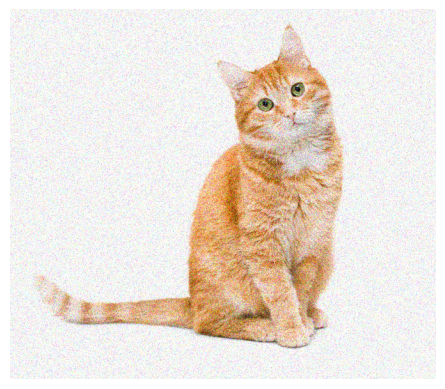

In [8]:
plt.imshow(imagen_ruidosa)
plt.axis("off")
plt.show()

A higher $\sigma$ value increases noise intensity. As in the case of brightness, the
operation is performed in floating point and the range is subsequently limited to obtain
a valid image.

### Masking Image Regions

Masking consists of nullifying or modifying specific regions of the image, typically
replacing them with a constant color. This procedure is useful for simulating occlusions,
applying techniques like Cutout, or highlighting certain areas.

Rectangular masking can be implemented directly by indexing rows and columns:

In [9]:
def enmascarar_region(image, x1, y1, x2, y2, color=(0, 0, 0)):
    """
    Masks a rectangular region of the image.
    Coordinates (x1, y1) and (x2, y2) define the upper left and lower right corners.
    """
    imagen_enmascarada = image.copy()
    imagen_enmascarada[y1:y2, x1:x2] = color
    return imagen_enmascarada

On the other hand, it is possible to mask a circular region using binary masks and OpenCV
drawing functions:

In [10]:
def enmascarar_circular(image, centro, radio, color=(0, 0, 0)):
    """
    Masks a circular region.
    centro: Tuple (x, y) with the center of the circle.
    radio: Radius of the circle in pixels.
    """
    imagen_enmascarada = image.copy()
    mascara = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.circle(mascara, centro, radio, 255, -1)
    imagen_enmascarada[mascara == 0] = color
    return imagen_enmascarada


# Example: Mask the center of the image with a rectangle
h, w = image_array.shape[:2]
imagen_con_mascara = enmascarar_region(
    image_array, w // 4, h // 4, 3 * w // 4, 3 * h // 4, color=(128, 128, 128)
)

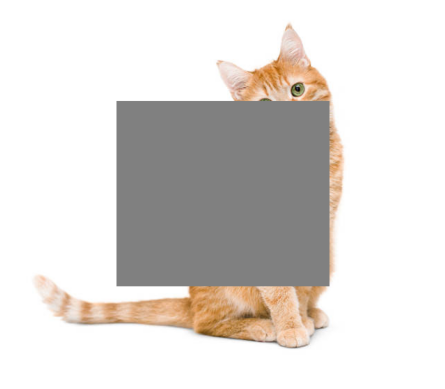

In [11]:
plt.imshow(imagen_con_mascara)
plt.axis("off")
plt.show()

This type of masking not only has value as an augmentation technique but also for
focusing analysis on regions of interest or for hiding sensitive information.

### Conversion to Grayscale

Converting an RGB image to grayscale reduces the three color channels to a single
dimension of luminous intensity. There are various methods to perform this
transformation. A simple approach uses PIL's native functionality:

In [12]:
def convertir_blanco_negro(image):
    """Convert image to grayscale using PIL."""
    image_pil = Image.fromarray(image).convert("L")
    return np.array(image_pil)

Another option consists of applying a weighted combination of the red, green, and blue
channels. A widely used standard formula is:

$$ I = 0.299 R + 0.587 G + 0.114 B $$

where $R$, $G$, and $B$ represent the intensities of each channel. This expression is
implemented in a vectorized manner with NumPy:

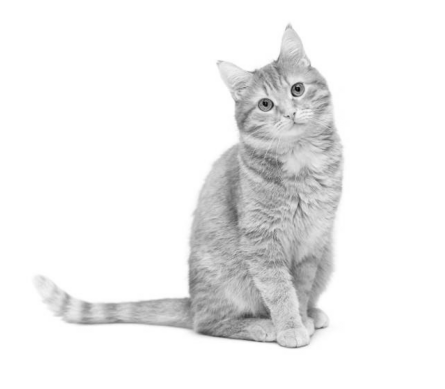

In [13]:
def convertir_bn_ponderado(image):
    """
    Manual weighted conversion to grayscale.
    Standard formula: 0.299*R + 0.587*G + 0.114*B.
    """
    return np.dot(image[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)


# Usage example
imagen_bn = convertir_blanco_negro(image_array)
plt.imshow(imagen_bn, cmap="gray")
plt.axis("off")
plt.show()

Both methods generate a single-channel image that can be visualized through a grayscale
color map. Grayscale conversion is used in applications where chromatic information is
not essential or when reducing data dimensionality is desired.

## Data Augmentation: Importance and Strategies

Data augmentation increases the effective diversity of the training set without the need
to acquire new images. This increase in variability contributes to reducing overfitting
and improves model generalization capacity, especially when the number of original
samples is limited.

Augmentation strategies can be grouped into several categories. Geometric
transformations, such as horizontal or vertical flips, rotations, cropping, or scaling,
modify the spatial arrangement of content. This promotes model invariance to changes in
orientation, translation, or scale.

Color-based transformations alter the chromatic characteristics of the image, including
adjustments to brightness, contrast, saturation, and hue. These operations seek
robustness against variations in illumination, capture devices, or environmental
conditions.

Noise-based techniques introduce stochastic perturbations, such as Gaussian or impulse
noise, that prepare the model for less ideal acquisition conditions. Advanced methods
like Cutout consist of randomly masking image regions, forcing the network not to depend
exclusively on small discriminative areas. Mixup, described earlier, linearly combines
multiple images and their labels, generating intermediate examples in the feature space.

Together, these augmentation strategies allow models to learn more robust representations
that are less sensitive to irrelevant data variations.

## Image Resizing and Normalization

Convolutional neural networks require input images to have fixed dimensions to be able to
process them in batches and maintain a coherent structure throughout the convolutional
layers. Standard values, such as $224 \times 224$ pixels, are common in pretrained models
(for example, in architectures trained on ImageNet), as they balance computational cost
and sufficient spatial resolution to capture relevant details.

Additionally, normalizing pixel intensities is essential for stabilizing training,
ensuring that gradients are properly scaled, and facilitating optimizer convergence.

### Resizing Techniques

Resizing can be carried out in various ways, depending on whether one wishes to preserve
the original aspect ratio, add padding, or crop the image. An example of a function that
implements several strategies is as follows:

In [14]:
def resize_image(image, target_size=(224, 224)):
    """Different resizing methods."""

    # Method 1: Simple resize (may distort aspect ratio)
    resized_simple = cv2.resize(image, target_size)

    # Method 2: Resize maintaining aspect ratio + padding
    h, w = image.shape[:2]
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    resized = cv2.resize(image, (new_w, new_h))

    # Add padding to complete to target size
    top = (target_h - new_h) // 2
    bottom = target_h - new_h - top
    left = (target_w - new_w) // 2
    right = target_w - new_w - left

    padded = cv2.copyMakeBorder(
        resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    # Method 3: Center crop (only if the image is larger than the target)
    if h > target_h or w > target_w:
        start_h = (h - target_h) // 2
        start_w = (w - target_w) // 2
        cropped = image[start_h : start_h + target_h, start_w : start_w + target_w]
    else:
        cropped = image

    return {
        "simple_resize": resized_simple,
        "resize_with_padding": padded,
        "center_crop": cropped,
    }


# Usage example
results = resize_image(image_array, target_size=(224, 224))

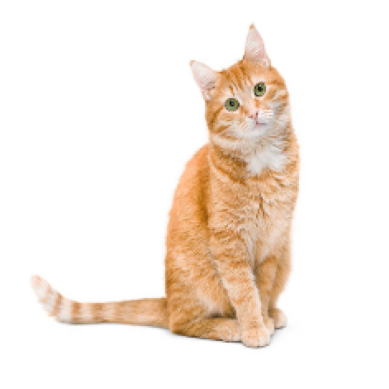

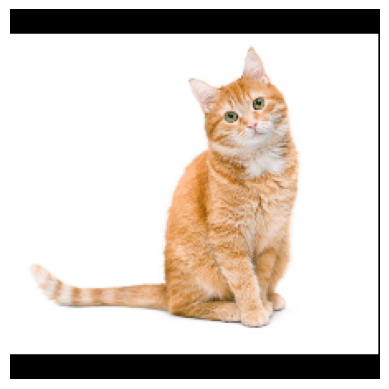

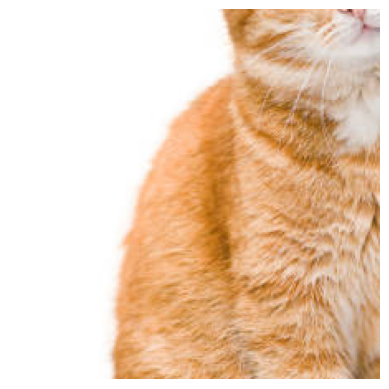

In [15]:
plt.imshow(results["simple_resize"])
plt.axis("off")
plt.show()

plt.imshow(results["resize_with_padding"])
plt.axis("off")
plt.show()

plt.imshow(results["center_crop"])
plt.axis("off")
plt.show()

Simple resizing directly adjusts the image to the specified size but may distort geometry
if the aspect ratio differs from the original. The approach that maintains the aspect
ratio and adds padding avoids this distortion by adding uniform bands around the image.
Finally, center cropping is useful when the image is larger and the most relevant
information is considered to be near the center.

### Complete Preprocessing Pipeline for CNNs

In practice, preprocessing pipelines are defined that chain several transformations
coherently. PyTorch, through the `torchvision.transforms` module, offers a compact way to
define these workflows. The following shows a standard pipeline for models pretrained on
ImageNet:

In [16]:
# 3pps
import torch
from torchvision import transforms


# Standard preprocessing pipeline for pretrained models
preprocess = transforms.Compose(
    [
        transforms.Resize(256),  # Resize to intermediate size
        transforms.CenterCrop(224),  # Center crop to 224x224
        transforms.ToTensor(),  # Convert to tensor [0, 1]
        transforms.Normalize(  # Normalize with ImageNet mean and std
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

The `ToTensor` transformation converts the image to a PyTorch tensor with shape
$(C, H, W)$ and automatically normalizes values to the range $[0, 1]$. Subsequently,
`Normalize` applies a channel-wise affine transformation:

$$ x' = \frac{x - \mu}{\sigma} $$

where $\mu$ is the mean and $\sigma$ is the standard deviation of pixel values for each
channel in the original training set (in this case, ImageNet). This normalization
homogenizes the input data scale, which facilitates optimization.

During training, data augmentation is typically incorporated directly into the pipeline,
while during validation a more conservative set of transformations is employed, without
randomness. A typical example is as follows:

In [17]:
# For training with augmentation
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# For validation (without augmentation)
val_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In the training pipeline, `RandomResizedCrop` randomly selects a region from the original
image and resizes it to $224 \times 224$, varying both scale and position.
`RandomHorizontalFlip` horizontally inverts the image with a predetermined probability,
while `ColorJitter` randomly modifies brightness, contrast, and saturation within bounded
ranges. In this way, each pass through the dataset generates slightly different versions
of the original images, which increases the effective data diversity.

In the validation pipeline, deterministic transformations are used to ensure that
evaluations are reproducible and comparable across epochs. Size and normalization are
kept consistent with the training pipeline, so that the model receives inputs in the same
feature space.